In [150]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', 50)
import re
import timeit
import random
random.seed(3)

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')


In [151]:
start = timeit.default_timer()
train = pd.read_csv('train_indessa.csv')
test = pd.read_csv('test_indessa.csv')
stop = timeit.default_timer()
print(stop - start)

17.37405299999955


In [152]:
target = train.loan_status.values
train.drop('loan_status', axis = 1, inplace = True)

In [153]:
size_train = train.shape[0]
size_test = test.shape[0]
full_df = train.append(test)

In [154]:
n = full_df.isnull().sum(axis=1)
full_df['nulls'] = n

In [155]:
drop_cols = ['emp_title','mths_since_last_major_derog', 'batch_enrolled', 'member_id', 'mths_since_last_record']
full_df.drop(drop_cols, axis = 1, inplace = True)

#### Clean Title

In [156]:
def clean_title(raw):
    if ('debt' in raw) or ('consol' in raw) or ('lidation' in raw):
        return 'debt consolidation'
    elif ('credit' in raw) or ('card' in raw):
        return 'credit card'
    elif 'wedd' in raw or 'marr' in raw:
        return 'wedding'
    elif 'home' in raw or 'house' in raw or 'bath' in raw:
        return 'home'
    elif ('car' in raw) or ('motor' in raw) or ('truck' in raw) or ('auto') in raw:
        return 'vehicle'
    elif ('payoff' in raw) or ('off' in raw) :
        return 'payoff'
    elif 'freedom' in raw:
        return 'freedom'
    elif 'pool' in raw:
        return 'pool'
    elif 'persona' in raw :
        return 'personal'
    elif 'vacation' in raw:
        return 'vacation'
    elif 'hosp' in raw or 'med' in raw:
        return 'medical'
    elif 'loan' in raw:
        return 'some loan'
    elif 'movin' in raw:
        return 'moving'
    else :
        return raw

full_df['title'] = full_df.title.apply(lambda x : x.lower() if type(x) == str else '')
full_df['title'] = full_df.title.apply(clean_title)

In [157]:
full_df['term'].value_counts()

36 months    621125
60 months    266254
Name: term, dtype: int64

In [158]:
col = full_df['emp_length']
for element in col:
    if type(element) is not float:
        print(element)
        break

9 years


In [159]:
title_list = full_df.title.values

from collections import Counter
wordsDict = Counter(title_list)
wordsDictSorted = wordsDict.most_common()
wordsDictSorted = dict(wordsDictSorted)

title_list = []
for i in wordsDictSorted:
    if wordsDictSorted[i] > 1:
        title_list.append(i)
    else :
        break

In [160]:
def final_title(raw):
    if raw in title_list:
        return raw
    else :
        return 'Other 2'
full_df['title'] = full_df.title.apply(final_title)

#### Helping functions to clean different columns

In [161]:
def get_emp_length(raw):
    if pd.isnull(raw):
        return np.nan
    if raw == 'n/a':
        return np.nan
    elif '+' in raw :
        return 10
    elif '<' in raw :
        return 1
    else :
        return int(re.sub("\D", "", raw))
    
def get_last_week_pay(raw) :
    try :
        return int(re.sub("\D", "", raw))
    except :
        return -9999
    
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
def clean_text(raw_text):
    cleantext = np.nan
    if type(raw_text) == str :
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', raw_text)
        cleantext = cleantext.replace('>', '')
        cleantext = ' '.join(cleantext.split())
        
        stop_words = set(stopwords.words("english"))
        words = word_tokenize(cleantext)
        
        filtered_sentence = []

        for w in words:
            if w not in stop_words:
                filtered_sentence.append(w)
        return len(filtered_sentence)
    
    else :
        return 0 

def verification_status_joint(raw):
    if type(raw) == str:
        return 1
    else :
        return -9999

In [162]:
Term1 = [x[:-7] for x in train['term']]

In [163]:
train['term'].value_counts()

36 months    372793
60 months    159635
Name: term, dtype: int64

In [164]:
train['term'] = Term1

In [165]:
train['home_ownership'].value_counts()

MORTGAGE    265940
RENT        213668
OWN          52664
OTHER          117
NONE            36
ANY              3
Name: home_ownership, dtype: int64

In [166]:
cleanup_ownership = {'home_ownership' :{'OWN': 4, 'MORTGAGE': 3, 'RENT' :2, 'OTHER':1, 'NONE':0, 'ANY': 3}}
train.replace(cleanup_ownership, inplace=True)
train.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,58189336,14350,14350,14350.0,36,,19.19,E,E3,clerk,9 years,4,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0
1,70011223,4800,4800,4800.0,36,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,3,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0
2,70255675,10000,10000,10000.0,36,BAT1586599,7.26,A,A4,Driver,2 years,4,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0
3,1893936,15000,15000,15000.0,36,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,2,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0
4,7652106,16000,16000,16000.0,36,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,2,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0


In [167]:
cleanup_grade = {'grade' :{'A': 4, 'B': 3, 'C' :2, 'D':1, 'E':0}}
train.replace(cleanup_grade, inplace=True)
train.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,58189336,14350,14350,14350.0,36,,19.19,0,E3,clerk,9 years,4,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0
1,70011223,4800,4800,4800.0,36,BAT1586599,10.99,3,B4,Human Resources Specialist,< 1 year,3,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0
2,70255675,10000,10000,10000.0,36,BAT1586599,7.26,4,A4,Driver,2 years,4,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0
3,1893936,15000,15000,15000.0,36,BAT4808022,19.72,1,D5,Us office of Personnel Management,10+ years,2,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0
4,7652106,16000,16000,16000.0,36,BAT2833642,10.64,3,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,2,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0


In [168]:
train.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,home_ownership,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,5.324280e+05,532428.000000,532428.000000,532428.000000,532428.000000,532428.000000,5.324250e+05,532428.000000,532412.000000,532412.000000,259874.000000,82123.000000,532412.000000,532412.000000,5.324280e+05,532141.000000,532412.000000,532428.000000,532428.000000,532428.000000,532428.000000,532333.000000,132980.000000,532412.000000,490424.000000,4.904240e+05,4.904240e+05
mean,3.500547e+07,14757.595722,14744.271291,14704.926696,13.242969,2.696962,7.502984e+04,18.138767,0.314448,0.694603,34.055735,70.093068,11.545594,0.194858,1.692128e+04,55.057189,25.267357,1753.428788,0.394954,45.717832,4.859221,0.014299,44.121462,0.005015,213.562222,1.395541e+05,3.208057e+04
std,2.412148e+07,8434.420080,8429.139277,8441.290381,4.379611,0.640217,6.519985e+04,8.369074,0.860045,0.997025,21.884797,28.139219,5.311442,0.583822,2.242322e+04,23.853436,11.843211,2093.199837,4.091546,409.647467,63.123361,0.133005,22.198410,0.079117,1958.571538,1.539149e+05,3.805304e+04
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,0.000000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.086688e+07,8000.000000,8000.000000,8000.000000,9.990000,2.000000,4.500000e+04,11.930000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.444000e+03,37.700000,17.000000,441.600000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,2.983975e+04,1.400000e+04
50%,3.709590e+07,13000.000000,13000.000000,13000.000000,12.990000,3.000000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187600e+04,56.000000,24.000000,1072.690000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.066950e+04,2.370000e+04
75%,5.848920e+07,20000.000000,20000.000000,20000.000000,16.200000,3.000000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.084300e+04,73.600000,32.000000,2234.735000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,2.084792e+05,3.980000e+04
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,4.000000,9.500000e+06,672.520000,30.000000,31.000000,180.000000,121.000000,90.000000,86.000000,2.568995e+06,892.300000,162.000000,24205.620000,358.680000,33520.270000,7002.190000,16.000000,180.000000,14.000000,496651.000000,8.000078e+06,9.999999e+06


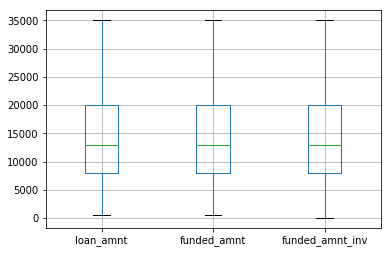

In [169]:
# full_df.boxplot(column=['loan_amnt', 'funded_amnt','funded_amnt_inv'])
train.boxplot(column=['loan_amnt', 'funded_amnt','funded_amnt_inv'])

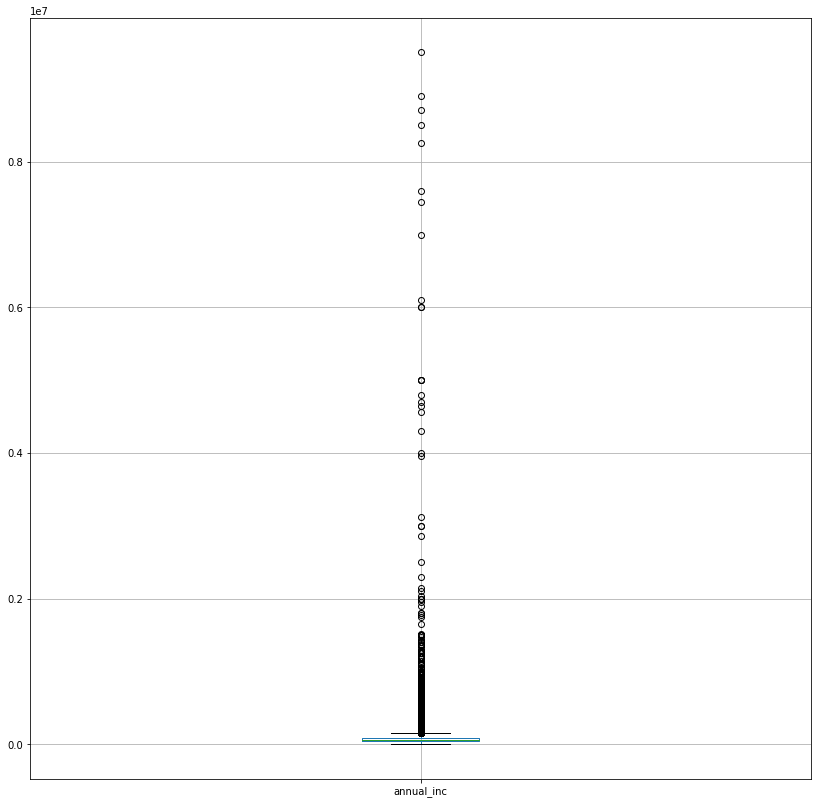

In [170]:
train.boxplot(column=['annual_inc'],figsize = (14,14))

In [171]:
#x=np.nan_to_num(x,0)
#sum(np.isnan(x))
#sum(np.isnan(y))
#y.max()

In [172]:
# plt.plot(train['annual_inc'], target,'.')
# plt.show()

##set1 = [(x,y,z) for (x,y,z) in zip(train['annual_inc'],train['loan_amnt'],target) if z ==0]
##set2 = [(x,y,z) for (x,y,z) in zip(train['annual_inc'],train['loan_amnt'],target) if z ==1]

# x, y, z = list(zip(*set1))
# plt.plot(x,y,'.',c='red',label="good")
# x, y, z = list(zip(*set2))
# plt.plot(x,y,'.',c='green',label="default")
# plt.legend()
# plt.xlim((0,100000))
# plt.show()

##x, y, z = list(zip(*set1))
#plt.hexbin(x,y,gridsize=(600,20))
#plt.xlim((0,500000))
#plt.colorbar()
#plt.show()

#x, y, z = list(zip(*set2))
#plt.hexbin(x,y,gridsize=(400,20))
#plt.xlim((0,500000))
#plt.colorbar()
#plt.show()

#from scipy.stats import kde
 

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents

#nbins=300
#x=np.nan_to_num(x,0)
#y=np.array(y)
#k = kde.gaussian_kde([x,y])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
#plt.show()
 
# Change color palette
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
#plt.show()


In [173]:
#full_df['loan_amnt'].boxplot()
#plt.show()
#full_df['funded_amnt'].hist()
#plt.show()

In [174]:
#plt.plot(train['annual_inc'], target,'.')

In [175]:
train.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,home_ownership,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,5.324280e+05,532428.000000,532428.000000,532428.000000,532428.000000,532428.000000,5.324250e+05,532428.000000,532412.000000,532412.000000,259874.000000,82123.000000,532412.000000,532412.000000,5.324280e+05,532141.000000,532412.000000,532428.000000,532428.000000,532428.000000,532428.000000,532333.000000,132980.000000,532412.000000,490424.000000,4.904240e+05,4.904240e+05
mean,3.500547e+07,14757.595722,14744.271291,14704.926696,13.242969,2.696962,7.502984e+04,18.138767,0.314448,0.694603,34.055735,70.093068,11.545594,0.194858,1.692128e+04,55.057189,25.267357,1753.428788,0.394954,45.717832,4.859221,0.014299,44.121462,0.005015,213.562222,1.395541e+05,3.208057e+04
std,2.412148e+07,8434.420080,8429.139277,8441.290381,4.379611,0.640217,6.519985e+04,8.369074,0.860045,0.997025,21.884797,28.139219,5.311442,0.583822,2.242322e+04,23.853436,11.843211,2093.199837,4.091546,409.647467,63.123361,0.133005,22.198410,0.079117,1958.571538,1.539149e+05,3.805304e+04
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,0.000000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.086688e+07,8000.000000,8000.000000,8000.000000,9.990000,2.000000,4.500000e+04,11.930000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.444000e+03,37.700000,17.000000,441.600000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,2.983975e+04,1.400000e+04
50%,3.709590e+07,13000.000000,13000.000000,13000.000000,12.990000,3.000000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187600e+04,56.000000,24.000000,1072.690000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.066950e+04,2.370000e+04
75%,5.848920e+07,20000.000000,20000.000000,20000.000000,16.200000,3.000000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.084300e+04,73.600000,32.000000,2234.735000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,2.084792e+05,3.980000e+04
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,4.000000,9.500000e+06,672.520000,30.000000,31.000000,180.000000,121.000000,90.000000,86.000000,2.568995e+06,892.300000,162.000000,24205.620000,358.680000,33520.270000,7002.190000,16.000000,180.000000,14.000000,496651.000000,8.000078e+06,9.999999e+06


In [176]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532428 entries, 0 to 532427
Data columns (total 44 columns):
member_id                      532428 non-null int64
loan_amnt                      532428 non-null int64
funded_amnt                    532428 non-null int64
funded_amnt_inv                532428 non-null float64
term                           532428 non-null object
batch_enrolled                 447279 non-null object
int_rate                       532428 non-null float64
grade                          532428 non-null object
sub_grade                      532428 non-null object
emp_title                      501595 non-null object
emp_length                     505537 non-null object
home_ownership                 532428 non-null int64
annual_inc                     532425 non-null float64
verification_status            532428 non-null object
pymnt_plan                     532428 non-null object
desc                           75599 non-null object
purpose                    

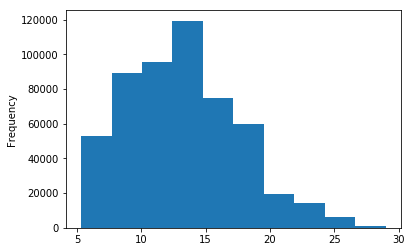

In [177]:
train['int_rate'].plot.hist()

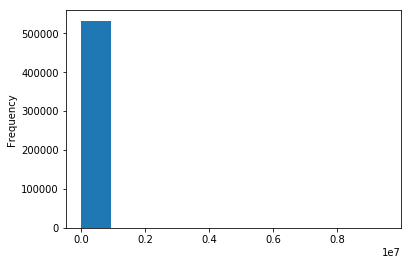

In [178]:
train['annual_inc'].plot.hist()

Text(0.5, 0, 'annual_inc')

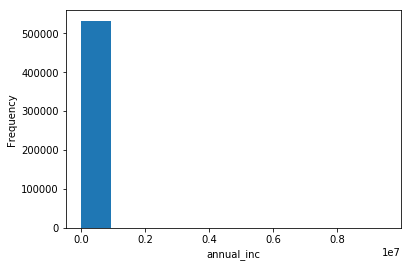

In [179]:
ax1=train['annual_inc'].plot.hist()
ax1.set_xlabel('annual_inc')

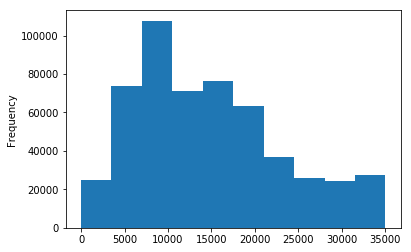

In [237]:
train['funded_amnt_inv'].plot.hist()

In [257]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
import numpy as np 

data2 = np.array(train['total_rec_int'])
# obtaining the pdf (my_pdf is a function!)
my_pdf2 = gaussian_kde(data2)

xmin, xmax = data2.min(), data2.max()
delta = (xmax-xmin)/10.

# plotting the result
x = np.linspace(0,35000,1000)
plt.hist(data2,alpha=.3,bins=10) # histogram
plt.xlabel('total_rec_int')
plt.plot(x,delta*len(data2)*my_pdf2(x),'r') # distribution function
plt.show()

ValueError: array must not contain infs or NaNs

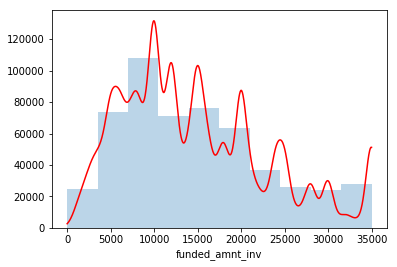

In [242]:
data1 = np.array(train['funded_amnt_inv'])
# obtaining the pdf (my_pdf is a function!)
my_pdf1 = gaussian_kde(data1)

xmin, xmax = data1.min(), data1.max()
delta = (xmax-xmin)/10.

# plotting the result
x = np.linspace(0,35000,1000)
plt.hist(data1,alpha=.3,bins=10) # histogram
plt.xlabel('funded_amnt_inv')
plt.plot(x,delta*len(data1)*my_pdf1(x),'r') # distribution function
plt.show()

Text(0.5, 0, 'log_total_rec_int')

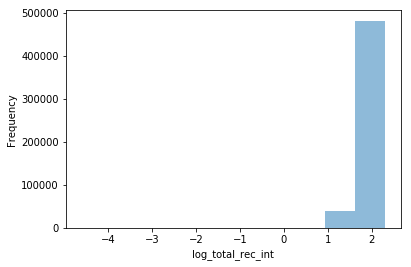

In [253]:
train['log_total_rec_int'] = train['total_rec_int'].apply(lambda x: np.log(x))
# train2['annual_inc'].plot.hist(alpha=0.4)
# train2['log_annual_inc'].plot.hist(alpha=0.4)
# plt.show()
train4 = train['log_total_rec_int']
ax4 = train4.plot.hist(alpha=.5,bins=10)
ax4.set_xlabel('log_total_rec_int')

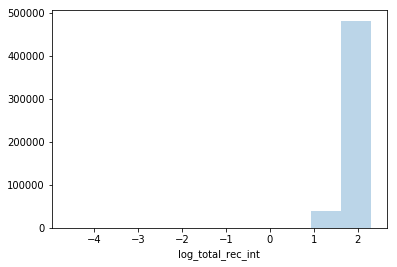

In [255]:

data6 = np.array(train['log_total_rec_int'])
# obtaining the pdf (my_pdf is a function!)
my_pdf6 = gaussian_kde(data1)

xmin, xmax = data6.min(), data6.max()
delta = (xmax-xmin)/10.

# plotting the result
x = np.linspace(-4,4,100)
plt.hist(data6,alpha=.3,bins=10) # histogram
plt.xlabel('log_total_rec_int')
plt.plot(x,delta*len(data6)*my_pdf6(x),'r') # distribution function
plt.show()

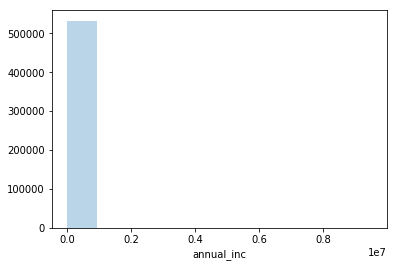

In [258]:
data5 = np.array(train['annual_inc'])
# obtaining the pdf (my_pdf is a function!)
my_pdf5 = gaussian_kde(data1)

xmin, xmax = data5.min(), data5.max()
delta = (xmax-xmin)/10.

# plotting the result
x = np.linspace(0,1e7,1000)
plt.hist(data5,alpha=.3,bins=10) # histogram
plt.xlabel('annual_inc')
plt.plot(x,delta*len(data5)*my_pdf5(x),'r') # distribution function
plt.show()

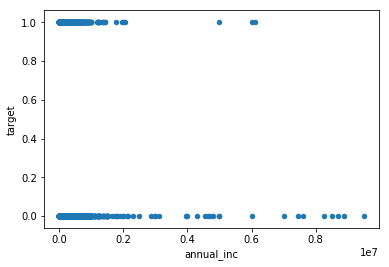

In [181]:
train['target']=target
#plt.plot(train['annual_inc', 'target'],'.')
train.plot.scatter('annual_inc', 'target')

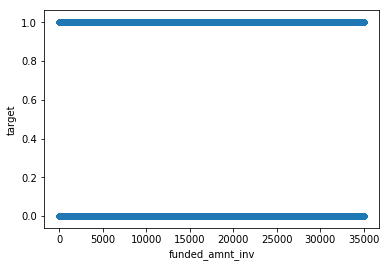

In [182]:
train.plot.scatter('funded_amnt_inv', 'target')

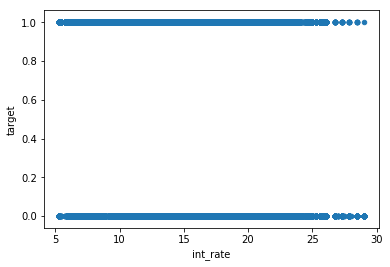

In [183]:
train.plot.scatter('int_rate', 'target')

In [184]:
import seaborn as sns

In [185]:
train.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'batch_enrolled', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'verification_status_joint', 'last_week_pay',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'target'],
      dtype='object')

In [186]:
train1= train[['target','member_id','loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'pymnt_plan','grade','emp_length'
       ,'batch_enrolled', 'int_rate', 'grade', 'emp_title', 'home_ownership', 'annual_inc', 
       'purpose', 'zip_code','total_rec_int','tot_cur_bal']]

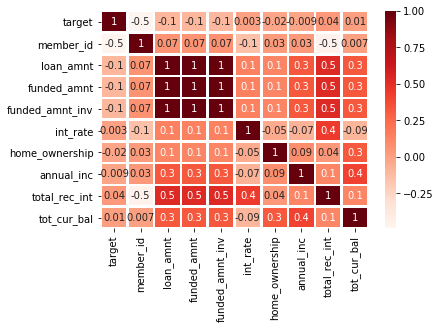

In [187]:

sns.heatmap(data = train1.corr(),annot=True, linewidths=1.5, fmt='.1g',cmap=plt.cm.Reds)


In [188]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [189]:
train2 = train.dropna(subset=['tot_cur_bal'])

In [190]:
features = ['funded_amnt_inv', 'term', 'int_rate', 'home_ownership', 'annual_inc','total_rec_int','tot_cur_bal']
X = train2[features].copy()
y = train2['target'].copy()

In [191]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.33)
X_train.shape[0] == y_train.shape[0]

True

In [192]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
regressor = LogisticRegression()
regressor = regressor.fit(X_train, y_train)

C:\Users\lcu1812\OneDrive\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [193]:
y_predicted = regressor.predict(X_test)
metrics.accuracy_score(y_test, y_predicted)

0.8100654967869501

In [195]:
# Calculate mean_squared_error
rmse = sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted))
rmse

0.43581475791103025

In [196]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_predicted).ravel()
print("tn = {}, fp = {},fn = {}, tp = {}".format(tn, fp, fn, tp))
tot = sum((tn, fp, fn, tp))
print("tn = {:0.3f}, fp = {:0.3f}, fn = {:0.3f}, tp = {:0.3f}".format(tn/tot, fp/tot, fn/tot, tp/tot))

recal = tp/(tp+fn)
precision = tp/(tp+fp)
print("\n")
print("recall = {recal:0.3f}, precision = {precision:0.3f}".format(recal=recal,precision=precision)) 

36    340438
60    149986
Name: term, dtype: int64

# Decision tree

In [197]:
from sklearn import tree

features = ['member_id','funded_amnt_inv', 'term', 'int_rate', 'home_ownership', 'annual_inc','total_rec_int','tot_cur_bal']
x = train2[features].copy()
y = train2['target'].copy()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.33)

regressor1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
regressor1 = regressor1.fit(x_train, y_train)

y_pred = regressor1.predict(x_test)

metrics.accuracy_score(y_test, y_pred)

0.8500679683638162

In [198]:
import random

best_score = 0
for i in range(50):
    try_features = random.sample(list(train2.columns),6)
    x = train2[features].copy()
    y = train2['target'].copy()

    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.33)

    regressor1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
    regressor1 = regressor1.fit(x_train, y_train)

    y_pred = regressor1.predict(x_test)

    try_score = metrics.accuracy_score(y_test, y_pred)
    if try_score > best_score:
        best_score = try_score
        best_features = try_features
print("Best accuracy: {score}\nfor: {features}".format(score=best_score,features=best_features))

Best accuracy: 0.8508156203657934
for: ['batch_enrolled', 'delinq_2yrs', 'tot_coll_amt', 'verification_status', 'mths_since_last_major_derog', 'revol_util']


In [199]:
y_pred = regressor1.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.8484305486900643

In [200]:
# x11=np.dot(y_pred, y_train)

# x12=np.dot(y_pred, 1-y_train)

# x21=np.dot(1-y_pred, y_train)

# x22=np.dot(1-y_pred, 1-y_train)

# print("{x11}\t{x12}\n{x21}\t{x22}".format(x11=x11,x12=x12,x21=x21,x22=x22))
# # print(x11+x12+x21+x22)
# # print(len(y_pred))

recall is calculated as tp/(tp+fn), how good the model is in term of correctly predicting default over total actual default. (correctly predicting yes/total actuall yes)

precision = tp/fp+tp: how many predicting "yes" is correct (correctly predicting yes/total predicting yes)



where
tp = true positive  (i.e. actual = default,     predict = default)
fp = false positive (i.e. actual = not default, predict =  default)
fn = false negative (i.e. actual = default,     predict = not default)
tn = true negative  (i.e. actual = not default, predict = not default)

recall = tp/

In [201]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()
print("tn = {}, fp = {}, fn = {}, tp = {}".format(tn, fp, fn, tp))
tot = sum((tn, fp, fn, tp))
print("tn = {:0.3f}, fp = {:0.3f}, fn = {:0.3f}, tp = {:0.3f}".format(tn/tot, fp/tot, fn/tot, tp/tot))

recal = tp/(tp+fn)
precision = tp/(tp+fp)
print("\n")
print("recall = {recal:0.3f}, precision = {precision:0.3f}".format(recal=recal,precision=precision))


tn = 126952, fp = 4351, fn = 20179, tp = 10358
tn = 0.784, fp = 0.027, fn = 0.125, tp = 0.064


recall = 0.339, precision = 0.704


# taking log of a column

In [202]:
features

['member_id',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'home_ownership',
 'annual_inc',
 'total_rec_int',
 'tot_cur_bal']

In [203]:
# train2['annual_inc'].plot.hist()
train2['log_annual_inc'] = train2['annual_inc'].apply(lambda x: np.log(x))
# train2['annual_inc'].plot.hist(alpha=0.4)
# train2['log_annual_inc'].plot.hist(alpha=0.4)
# plt.show()
train3 = train2['log_annual_inc']


C:\Users\lcu1812\OneDrive\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 0, 'log_annual_inc')

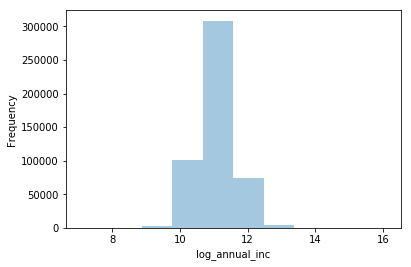

In [204]:
# train2['annual_inc'].plot.hist(alpha=0.4)
ax2 = train3.plot.hist(alpha=0.4)
ax2.set_xlabel('log_annual_inc')



In [205]:
def print_lots_of_data():
    print(metrics.accuracy_score(y_test, y_pred))

    tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()
    print("tn = {}, fp = {}, fn = {}, tp = {}".format(tn, fp, fn, tp))
    tot = sum((tn, fp, fn, tp))
    print("tn = {:0.3f}, fp = {:0.3f}, fn = {:0.3f}, tp = {:0.3f}".format(tn/tot, fp/tot, fn/tot, tp/tot))

    recal = tp/(tp+fn)
    precision = tp/(tp+fp)
    print("\n")
    print("recall = {recal:0.3f}, precision = {precision:0.3f}".format(recal=recal,precision=precision))

In [228]:
from sklearn import tree

features = ['member_id','funded_amnt_inv', 'term', 'int_rate', 'home_ownership', 'log_annual_inc','total_rec_int','tot_cur_bal']
x = train2[features].copy()
y = train2['target'].copy()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.33)

regressor1 = tree.DecisionTreeClassifier(criterion='entropy')
regressor1 = regressor1.fit(x_train, y_train)

y_pred = regressor1.predict(x_test)

print_lots_of_data()


0.8574023727137914
tn = 120174, fp = 11276, fn = 11802, tp = 18588
tn = 0.743, fp = 0.070, fn = 0.073, tp = 0.115


recall = 0.612, precision = 0.622


now without log

In [229]:
from sklearn import tree

features1 = ['member_id','funded_amnt_inv', 'term', 'int_rate', 'home_ownership', 'annual_inc','total_rec_int','tot_cur_bal']
x = train2[features1].copy()
y = train2['target'].copy()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.33)

regressor1 = tree.DecisionTreeClassifier(criterion='entropy')
regressor1 = regressor1.fit(x_train, y_train)

y_pred = regressor1.predict(x_test)

print_lots_of_data()

0.8584404349975284
tn = 120034, fp = 11318, fn = 11592, tp = 18896
tn = 0.742, fp = 0.070, fn = 0.072, tp = 0.117


recall = 0.620, precision = 0.625


In [222]:
# X_train['term'].value_counts()

36    227996
60    100588
Name: term, dtype: int64

In [225]:
from sklearn import tree

features2 = ['funded_amnt_inv', 'term', 'int_rate', 'home_ownership', 'annual_inc','total_rec_int','tot_cur_bal']
x = train2[features2].copy()
y = train2['target'].copy()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.33)

regressor2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
regressor2 = regressor1.fit(x_train, y_train)

y_pred1 = regressor2.predict(x_test)

metrics.accuracy_score(y_test, y_pred1)

0.8140138408304498

In [209]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
x, y = load_iris(return_X_y=True)
regressor = LogisticRegression()
regressor2 = regressor.fit(x_train, y_train)

y_predicted = regressor2.predict(x_test)

C:\Users\lcu1812\OneDrive\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [210]:
regressor2.score(x_test, y_test)

0.8164359861591696

In [211]:
rmse = sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted))
rmse

0.4284437114030622

In [212]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_predicted).ravel()
print("tn = {}, fp = {}, fn = {}, tp = {}".format(tn, fp, fn, tp))
tot = sum((tn, fp, fn, tp))
print("tn = {:0.3f}, fp = {:0.3f}, fn = {:0.3f}, tp = {:0.3f}".format(tn/tot, fp/tot, fn/tot, tp/tot))

recal = tp/(tp+fn)
precision = tp/(tp+fp)
print("\n")
print("recall = {recal:0.3f}, precision = {precision:0.3f}".format(recal=recal,precision=precision))

tn = 130274, fp = 1062, fn = 28646, tp = 1858
tn = 0.805, fp = 0.007, fn = 0.177, tp = 0.011


recall = 0.061, precision = 0.636


In [213]:
# regressor1.score(X_test, y_test)

In [214]:
# rmse = sqrt(mean_squared_error(y_true=y_test,y_pred=y_predicted1))
# rmse 

In [215]:
# pip install pydotplus

In [216]:
# conda install graphviz

In [217]:
# conda install python-graphviz

In [230]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [259]:
xdata = list(range(2,12))
ydata = {}

criteria = "gini", "entropy"

for criterion in criteria:
    ydata[criterion] = []
    for x in xdata:
        
        # Create Decision Tree classifer object
        clf = tree.DecisionTreeClassifier(criterion=criterion, max_depth=x)

        # Train Decision Tree Classifer
        clf = clf.fit(x_train,y_train)

        #Predict the response for test dataset
        y_pred = clf.predict(x_test)

        # Model Accuracy, how often is the classifier correct?
        ydata[criterion].append(metrics.accuracy_score(y_test, y_pred))



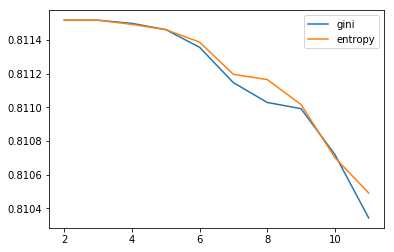

In [220]:
for criterion in criteria:
    plt.plot(xdata, ydata[criterion], label=criterion)
plt.legend()
plt.show()

In [260]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features1,  class_names = ['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write("graph.svg", format="svg")
graph.write("graph.png", format="png")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.163409 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.163409 to fit



True

In [ ]:
full_df['term'] = full_df['term'].apply(lambda x : int(re.sub("\D", "", x)))
full_df['emp_length'] = full_df['emp_length'].apply(get_emp_length)
full_df['last_week_pay'] = full_df['last_week_pay'].apply(get_last_week_pay)
full_df['desc'] = full_df['desc'].apply(clean_text)
full_df['verification_status_joint'] = full_df['verification_status_joint'].apply(verification_status_joint)

In [ ]:
cols_list = full_df.columns
cols_obj = []
obj_list = full_df.dtypes.values
for col, obj in zip(cols_list, obj_list):
    if obj == object:
        cols_obj.append(col)
        
#full_df[cols_obj].count()

In [ ]:
le = preprocessing.LabelEncoder()
for col in cols_obj:
    full_df[col] = le.fit_transform(full_df[col])

In [ ]:
def fill_nulls(value):
    cols_fill = ['emp_length', 'annual_inc','delinq_2yrs', 'inq_last_6mths', 
            'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util',
            'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
            'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
    
    if value == -9999:
        for col in cols_fill:
            full_df.loc[full_df[col].isnull(), col] = -9999
    else : 
        for col in cols_fill:
            full_df.loc[full_df[col].isnull(), col] = full_df[col].median()

In [ ]:
fill_nulls(-9999)

#### New features

In [ ]:
value = -9999

def helping_features(value):
    full_df['Interest'] = full_df['funded_amnt']*full_df['int_rate']*full_df['term']/(100*12)
    if value == -9999:
        full_df['Monthly_income'] = full_df['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)
        full_df['Monthly_debt_repay'] = full_df['Monthly_income'] * full_df['dti']/100
        full_df['Monthly_debt_repay'] = full_df['Monthly_debt_repay'].apply(lambda x : x if x>0 else -9999) 
    else :
        full_df['Monthly_income'] = full_df['annual_inc']/12
        full_df['Monthly_debt_repay'] = full_df['Monthly_income'] * full_df['dti']/100
    

In [ ]:
helping_features(-9999)

In [ ]:
full_df.head()

In [ ]:
full_df['unpaid_perc'] = (full_df['Interest'] - full_df['total_rec_int'])/full_df['Interest']

In [ ]:
full_df['last_to_term'] = full_df['last_week_pay']/(full_df['term']*52/12)

In [ ]:
full_df['monthly_int_to_debt_repay'] = full_df['Interest']/full_df['Monthly_debt_repay']/12

In [ ]:
full_df['iti'] = full_df['Interest']/full_df['Monthly_income']/12

In [ ]:
full_df['dti_and_iti'] = full_df['iti'] + full_df['dti']

In [ ]:
full_df['dtc'] = full_df['Monthly_debt_repay']/full_df['total_rev_hi_lim']/12

In [ ]:
full_df['itc'] = full_df['Interest']/full_df['total_rev_hi_lim']/(12*12)

In [ ]:
cols = []
for col in full_df.columns:
    if col not in ['Interest', 'total_rec_int','Monthly_income', 'Monthly_debt_repay','last_to_term',
                   'dti_and_iti']:
        cols.append(col)

In [ ]:
train_new = full_df[:size_train]
test_new = full_df[size_train:]

train_new = train_new[cols]
test_new = test_new[cols]

In [ ]:
import xgboost as xgb
param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 0
param['eval_metric'] = "auc"
param['subsample'] = 1
param['colsample_bytree'] = 1
param['seed'] = 3
num_rounds = 5000

In [ ]:
kf = KFold(n_splits=2, shuffle=True, random_state=3)

for train_index, test_index in kf.split(train_new):    
    print("Split")
    model = train_xgb(train_new.iloc[train_index].values, target[train_index], train_new.iloc[test_index].values, target[test_index])

In [ ]:
def train_xgb(X_train, y_train, X_val, y_val):
    
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-9999)
    
    dtest = xgb.DMatrix(X_val, label=y_val, missing=-9999)
    
    watchlist  = [(dtest,'test'), (dtrain,'train')]
    bst = xgb.train(param, dtrain, num_rounds, watchlist, early_stopping_rounds=20)
    
    return bst
    #print(get_log_loss(y_val, pred), get_log_loss(y_train, predtrain))

In [ ]:
def ceate_feature_map(features):
    outfile = open('xgb_new.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

def xgb_feature_importance(features, model):
    ceate_feature_map(features)
    
    import operator
    importance = model.get_fscore(fmap='xgb_new.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))
    
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    plt.figure()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.show()
    
    return df

In [ ]:
featuredf = xgb_feature_importance(test_new.columns, model)

In [ ]:
def predict_xgb(X_train, y_train, X_test):
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-9999)
    
    dtest = xgb.DMatrix(X_test, missing=-9999)
    
    bst = xgb.train(param, dtrain, num_rounds, early_stopping_rounds = 20)
    
    pred = bst.predict(dtest)
    
    return pred

In [ ]:
def train_and_predict(X_train, y_train, X_val, y_val, X_test):
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-9999)
    dtest = xgb.DMatrix(X_val, label=y_val, missing=-9999)
    watchlist  = [(dtest,'test'), (dtrain,'train')]
    bst = xgb.train(param, dtrain, num_rounds, watchlist, early_stopping_rounds=20)
    
    bst.save_model('mymodel')
    bst = xgb.Booster(param)
    bst.load_model('mymodel')
    
    #xgboost issue : https://github.com/dmlc/xgboost/issues/1238
    
    dpredict = xgb.DMatrix(X_test, missing=-9999)
    pred = bst.predict(dpredict)
    return pred

In [ ]:
import xgboost as xgb
param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.03
param['max_depth'] = 10
param['silent'] = 0
param['eval_metric'] = "auc"
param['subsample'] = 1
param['colsample_bytree'] = 1
param['seed'] = 3
num_rounds = 5000

In [ ]:
### Final predict
kf = KFold(n_splits=5, shuffle=True, random_state=3)
pred_arr = []

for train_index, test_index in kf.split(train_new):    
    print("Split")
    pred_temp = train_and_predict(train_new.iloc[train_index].values, target[train_index], train_new.iloc[test_index].values, target[test_index], test_new)
    print(pred_temp[1:15])
    pred_arr.append(pred_temp)

In [ ]:
pred1 = pred_arr[0]
pred2 = pred_arr[1]
pred3 = pred_arr[2]
pred4 = pred_arr[3]
pred5 = pred_arr[4]

In [ ]:
pred_avg = (pred1+pred2+pred3+pred4+pred5)/5

In [ ]:
pred_avg = (pred1+pred2+pred3+pred4+pred5)/5
print(pred_avg[1:5])

In [ ]:
test = pd.read_csv('test_indessa.csv')
member_id = test.member_id

In [ ]:
ans = pd.DataFrame({
    'member_id' : member_id,
    'loan_status' : pred_avg
})
ans = ans[['member_id','loan_status']]

In [ ]:
ans.to_csv('answer_f_5000_rounds_eta_03_1.csv', index = False) ### 0.97892 on lb and (0.97927 after ensemble with prev models)

In [ ]:
df_full.head()